# **XAI-Methoden angewendet auf den Review Datensatz**

- Hier werden alle XAI Modell initialisiert und verglichen. Preprocessing und Modell-Training wird ausgelagert in eigenen Modulen.

- Die XAI-Techniken werden nacheinander auf die Präfixe angewendet. Hierbei wird eine XAI-Technik direkt auf alle Präfixe angewendet

- Zuletzt werden die Evaluations-Ergebnisse visualisiert

## Packages installieren
 

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
#!pip install dive-into-graphs

In [ ]:
%%capture
!git clone https://github.com/divelab/DIG.git
%cd DIG
!pip install .

In [ ]:
%%capture
!pip install pm4py

In [ ]:
# Hauptordner-Pfad
import torch
from pathlib import Path
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM" 

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import random


import torch
import joblib
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from models.gcn3_neu import *

from torch_geometric.data.batch import Batch
from dig.xgraph.evaluation import XCollector
import tqdm as tqdm
import math

from dig.xgraph.method import PGExplainer
from dig.xgraph.method import GradCAM
from dig.xgraph.method import GNNExplainer
from utilities import RandomExplainer
from utilities_xai import train_pgexplainer, pgexplainer_prefix_run, gradcam_prefix_run, gnnexplainer_prefix_run, random_node_prefix_run, split_dataset_2_8, prediction_check
from train_gcn import load_gcn
from utilities_pgexplainer_tuning import save_hyperparam_results

from utilities import *



In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Datensatz laden

In [ ]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "review_all_events_f5_ohe_2_prefix"
dataset_list = torch.load(path / str("datasets/dataset_" + dataset_name))
feature = joblib.load("datasets/encoder_" + dataset_name + ".joblib")

In [ ]:
# Lediglich Präfixe einbeziehen
dataset_list.pop(0)
dataset_list.keys()

dict_keys([4, 7, 10, 13, 16, 19])

##Variablen

Hier sind alle Variablen zusammengefasst. Vor Ausführen der Datei können hier Konfigurationen vorgenommen werden

In [ ]:

# ---------------------------Trainingsdatensatz ------------------------
test_len = 300

# ---------------------------Variablen Model---------------------------

num_layer = 3
hidden_channel = 100

# ---------------------------Variablen XAI Methoden---------------------------
sparsity = 0.6    # Spärlichkeit: Wie viel Prozent des ursprünglichen Graphen aus der Erklärung ausgeschlossen werden soll
num_classes =  2  # Anzahl der Klassen: 0: Review wurde angenommen, 1: Review wurde abgelehnt
# PGExpaleiner
#ath_pgexplainer =  path / "xai_methods/pgexplainer/" # Speicherort für Parameter des PGExplainer
pgexplainer_name = f"{dataset_name}/pgexplainer" # Speicherort für Parameter des PGExplainer

# Save 
save_place = f"xai_results/prefix_{dataset_name}" 

#fast_test = ds_test[:test_len]

## XAI Methoden

###Grad-Cam

In [ ]:
# Speichern der Ergebnisse
collector_list_gradcam = []

for key in dataset_list:
  print(f'-------------Präfixes: {key}--------------')
  # Dataset
  dataset = dataset_list[key]
  ds_train, ds_val  = split_dataset_2_8(dataset)

  # Model instantiieren
  input_dim = dataset[0].x.size(1)
  model_name_pre = f"{dataset_name}_{str(key)}"
  model = load_gcn(model_name_pre, input_dim, device, path)

    # Nur richtige Vorhersagen des Models beachten
  fast_test = prediction_check(dataset, model, test_len, device)

  # Instaniieren des Explainers
  explainer_grad_cam = GradCAM(model, explain_graph=True)
  # Instantiieren des Collectors
  xCol_grad = XCollector()

  print("--------------Grad-Cam--------------------")
  for data in tqdm.tqdm(fast_test):
    
    data = data.to(device)
    xCol_grad = gradcam_prefix_run(data, xCol_grad, explainer_grad_cam, sparsity)
  #explainer_grad_cam.__clear_masks__()
  # Collector für key in Liste speichern
  collector_list_gradcam.append(xCol_grad)

# Evaluationsmetriken erhalten
sparsity_fidelity_grad_cam = [x.fidelity for x in collector_list_gradcam]
sparsity_fidelity_inv_grad_cam = [x.fidelity_inv for x in collector_list_gradcam]
sparsity_grad_cam = [x.sparsity for x in collector_list_gradcam]
results_grad_cam = [sparsity_fidelity_grad_cam, sparsity_fidelity_inv_grad_cam, sparsity_grad_cam  ]
#Speichern
joblib.dump(results_grad_cam, path/ save_place/ "results_grad_cam.joblib")
dict_results_grad_cam = {
    "Results - 4": [sparsity_fidelity_grad_cam[0], sparsity_fidelity_inv_grad_cam[0], sparsity_grad_cam[0]],
    "Results - 7": [sparsity_fidelity_grad_cam[1], sparsity_fidelity_inv_grad_cam[1], sparsity_grad_cam[1]],
    "Results - 10": [sparsity_fidelity_grad_cam[2], sparsity_fidelity_inv_grad_cam[2], sparsity_grad_cam[2]],
    "Results - 13": [sparsity_fidelity_grad_cam[3], sparsity_fidelity_inv_grad_cam[3], sparsity_grad_cam[3]],
    "Results - 16": [sparsity_fidelity_grad_cam[4], sparsity_fidelity_inv_grad_cam[4], sparsity_grad_cam[4]],
    "Results - 19": [sparsity_fidelity_grad_cam[5], sparsity_fidelity_inv_grad_cam[5], sparsity_grad_cam[5]]

}

save_hyperparam_results(dict_results_grad_cam, path/ save_place/ "results_grad_cam.yml")



  

-------------Präfixes: 4--------------
--------------Grad-Cam--------------------


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
100%|██████████| 300/300 [00:08<00:00, 34.78it/s]


-------------Präfixes: 7--------------
--------------Grad-Cam--------------------


100%|██████████| 300/300 [00:08<00:00, 35.16it/s]


-------------Präfixes: 10--------------
--------------Grad-Cam--------------------


100%|██████████| 300/300 [00:08<00:00, 35.09it/s]


-------------Präfixes: 13--------------
--------------Grad-Cam--------------------


100%|██████████| 300/300 [00:08<00:00, 34.59it/s]


-------------Präfixes: 16--------------
--------------Grad-Cam--------------------


100%|██████████| 300/300 [00:08<00:00, 34.80it/s]


-------------Präfixes: 19--------------
--------------Grad-Cam--------------------


100%|██████████| 300/300 [00:08<00:00, 34.34it/s]


save Hyperparameter


###Random-Node

In [ ]:
# Speichern der Ergebnisse
collector_list_random_node = [] 

for key in dataset_list:
  print(f'-------------Präfixes: {key}--------------')
  # Dataset
  dataset = dataset_list[key]
  ds_train, ds_val  = split_dataset_2_8(dataset)

  # Model instantiieren
  input_dim = dataset[0].x.size(1)
  model_name_pre = f"{dataset_name}_{str(key)}"
  model = load_gcn(model_name_pre, input_dim, device, path)

  # Nur richtige Vorhersagen des Models beachten
  fast_test = prediction_check(dataset, model, test_len, device)

  # Instaniieren des Explainers
  random_explainer = RandomExplainer()
  # Instantiieren des Collectors
  xCol_rand_node = XCollector()

  print("-------------Random-Node--------------------")
  for data in tqdm.tqdm(fast_test):
    
    data = data.to(device)
    xCol_rand_node = random_node_prefix_run(data, xCol_rand_node, random_explainer, sparsity, model)
  #explainer_grad_cam.__clear_masks__()
  # Collector für key in Liste speichern
  collector_list_random_node.append(xCol_rand_node)

# Evaluationsmetriken erhalten
sparsity_fidelity_random_node = [x.fidelity for x in collector_list_random_node]
sparsity_fidelity_inv_random_node = [x.fidelity_inv for x in collector_list_random_node]
sparsity_random_node = [x.sparsity for x in collector_list_random_node]
results_random_node = [sparsity_fidelity_random_node, sparsity_fidelity_inv_random_node, sparsity_random_node  ]
#Speichern
joblib.dump(results_random_node, path/ save_place/ "results_random_node.joblib")
dict_results_random_node = {
    "Results - 4": [sparsity_fidelity_random_node[0], sparsity_fidelity_inv_random_node[0], sparsity_random_node[0]],
    "Results - 7": [sparsity_fidelity_random_node[1], sparsity_fidelity_inv_random_node[1], sparsity_random_node[1]],
    "Results - 10": [sparsity_fidelity_random_node[2], sparsity_fidelity_inv_random_node[2], sparsity_random_node[2]],
    "Results - 13": [sparsity_fidelity_random_node[3], sparsity_fidelity_inv_random_node[3], sparsity_random_node[3]],
    "Results - 16": [sparsity_fidelity_random_node[4], sparsity_fidelity_inv_random_node[4], sparsity_random_node[4]],
    "Results - 19": [sparsity_fidelity_random_node[5], sparsity_fidelity_inv_random_node[5], sparsity_random_node[5]]

}

save_hyperparam_results(dict_results_random_node, path/ save_place/ "results_random_node.yml")

-------------Präfixes: 4--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 114.82it/s]


-------------Präfixes: 7--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 113.23it/s]


-------------Präfixes: 10--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 115.40it/s]


-------------Präfixes: 13--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 115.75it/s]


-------------Präfixes: 16--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 111.72it/s]


-------------Präfixes: 19--------------
-------------Random-Node--------------------


100%|██████████| 300/300 [00:02<00:00, 111.64it/s]


save Hyperparameter


### PGExplainer

In [ ]:
param_all_pge = {
    4:{
        "lr": 0.05,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    },
    7:{
        "lr": 0.005,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    },
    10:{
        "lr": 0.01,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    },
    13:{
        "lr": 0.05,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    },
    16:{
        "lr": 0.01,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    },
    19:{
        "lr": 0.005,
        "coff_size": 0.01, 
        "coff_ent": 0.0005, 
        "t0": 5.0,
        "t1": 1.0,
        "epochs": 20
    }



}

In [ ]:
# Speichern der Ergebnisse
collector_list_pge= []

for key in dataset_list:
  print(f'-------------Präfixes: {key}--------------')
  # Dataset
  dataset = dataset_list[key]
  ds_train, ds_val  = split_dataset_2_8(dataset)

  # Model instantiieren
  input_dim = dataset[0].x.size(1)
  name_pge = f"{dataset_name}_{str(key)}"
  model = load_gcn(name_pge, input_dim, device, path)

    # Nur richtige Vorhersagen des Models beachten
  fast_test = prediction_check(dataset, model, test_len, device)

  # Instaniieren des Explainers 
  param = param_all_pge[key]
  explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )
  # Train PGExplainer oder laden gespeicherter Parameter für den Datensatz
  explainer_pge = train_pgexplainer(explainer_pge, False, ds_train, path, f"{name_pge}/pgexplainer")
  # Instantiieren des Collectors
  xCol_pge = XCollector()

  print("--------------PGE-Explainer--------------------")
  for data in tqdm.tqdm(fast_test):
    
    data = data.to(device)
    xCol_pge = pgexplainer_prefix_run(data, xCol_pge, explainer_pge, sparsity)
  #explainer_grad_cam.__clear_masks__()
  # Collector für key in Liste speichern
  collector_list_pge.append(xCol_pge)

# Evaluationsmetriken erhalten
sparsity_fidelity_pge = [x.fidelity for x in collector_list_pge]
sparsity_fidelity_inv_pge = [x.fidelity_inv for x in collector_list_pge]
sparsity_pge = [x.sparsity for x in collector_list_pge]
results_pge = [sparsity_fidelity_pge, sparsity_fidelity_inv_pge, sparsity_pge  ]
#Speichern
joblib.dump(results_pge, path/ save_place/ "results_pge.joblib")
dict_results_pge = {
    "Results - 4": [sparsity_fidelity_pge[0], sparsity_fidelity_inv_pge[0], sparsity_pge[0]],
    "Results - 7": [sparsity_fidelity_pge[1], sparsity_fidelity_inv_pge[1], sparsity_pge[1]],
    "Results - 10": [sparsity_fidelity_pge[2], sparsity_fidelity_inv_pge[2], sparsity_pge[2]],
    "Results - 13": [sparsity_fidelity_pge[3], sparsity_fidelity_inv_pge[3], sparsity_pge[3]],
    "Results - 16": [sparsity_fidelity_pge[4], sparsity_fidelity_inv_pge[4], sparsity_pge[4]],
    "Results - 19": [sparsity_fidelity_pge[5], sparsity_fidelity_inv_pge[5], sparsity_pge[5]]

}

save_hyperparam_results(dict_results_pge, path/ save_place/ "results_pge.yml")

-------------Präfixes: 4--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 71.79it/s]


-------------Präfixes: 7--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 71.53it/s]


-------------Präfixes: 10--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 72.16it/s]


-------------Präfixes: 13--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 71.78it/s]


-------------Präfixes: 16--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 71.62it/s]


-------------Präfixes: 19--------------
--------------PGE-Explainer--------------------


100%|██████████| 300/300 [00:04<00:00, 71.86it/s]


save Hyperparameter


### GNNExplainer

In [ ]:
param_all_gnne = {
    4:{
        "lr": 0.001,
        "epochs": 500
    },
    7:{
        "lr": 0.001,
        "epochs": 500
    },
    10:{
        "lr": 0.001,
        "epochs": 500
    },
    13:{
        "lr": 0.001,
        "epochs": 500
    },
    16:{
        "lr": 0.001,
        "epochs": 500
    },
    19:{
        "lr": 0.001,
        "epochs": 500
    },

}


In [ ]:
# Speichern der Ergebnisse
collector_list_gnne = []

for key in dataset_list:
  print(f'-------------Präfixes: {key}--------------')
  # Dataset
  dataset = dataset_list[key]
  ds_train, ds_val  = split_dataset_2_8(dataset)

  # Model instantiieren
  input_dim = dataset[0].x.size(1)
  model_name_pre = f"{dataset_name}_{str(key)}"
  model = load_gcn(model_name_pre, input_dim, device, path)

    # Nur richtige Vorhersagen des Models beachten
  fast_test = prediction_check(dataset, model, test_len, device)

  # Instaniieren des Explainers
  param = param_all_gnne[key]
  explainer_gnnexplainer = GNNExplainer(model, epochs=param["epochs"], lr=param["lr"], explain_graph=True)
  # Instantiieren des Collectors
  xCol_gnne = XCollector()

  print("--------------GNNExplainer--------------------")
  for data in tqdm.tqdm(fast_test):
    
    data = data.to(device)
    xCol_gnne = gnnexplainer_prefix_run(data, xCol_gnne, explainer_gnnexplainer, sparsity)
  #explainer_grad_cam.__clear_masks__()
  # Collector für key in Liste speichern
  collector_list_gnne.append(xCol_gnne)

# Evaluationsmetriken erhalten
sparsity_fidelity_gnne = [x.fidelity for x in collector_list_gnne]
sparsity_fidelity_inv_gnne = [x.fidelity_inv for x in collector_list_gnne]
sparsity_gnne = [x.sparsity for x in collector_list_gnne]
results_gnne = [sparsity_fidelity_gnne, sparsity_fidelity_inv_gnne, sparsity_gnne  ]
#Speichern
joblib.dump(results_gnne, path/ save_place/ "results_gnne.joblib")
dict_results_gnne = {
    "Results - 4": [sparsity_fidelity_gnne[0], sparsity_fidelity_inv_gnne[0], sparsity_gnne[0]],
    "Results - 7": [sparsity_fidelity_gnne[1], sparsity_fidelity_inv_gnne[1], sparsity_gnne[1]],
    "Results - 10": [sparsity_fidelity_gnne[2], sparsity_fidelity_inv_gnne[2], sparsity_gnne[2]],
    "Results - 13": [sparsity_fidelity_gnne[3], sparsity_fidelity_inv_gnne[3], sparsity_gnne[3]],
    "Results - 16": [sparsity_fidelity_gnne[4], sparsity_fidelity_inv_gnne[4], sparsity_gnne[4]],
    "Results - 19": [sparsity_fidelity_gnne[5], sparsity_fidelity_inv_gnne[5], sparsity_gnne[5]]

}

save_hyperparam_results(dict_results_gnne, path/ save_place/ "results_gnne.yml")

-------------Präfixes: 4--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:12<00:00,  4.24s/it]


-------------Präfixes: 7--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:12<00:00,  4.24s/it]


-------------Präfixes: 10--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:11<00:00,  4.24s/it]


-------------Präfixes: 13--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:10<00:00,  4.23s/it]


-------------Präfixes: 16--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:09<00:00,  4.23s/it]


-------------Präfixes: 19--------------
--------------GNNExplainer--------------------


100%|██████████| 300/300 [21:13<00:00,  4.25s/it]

save Hyperparameter


In [ ]:
from utilities_xai import plot_results_prefix

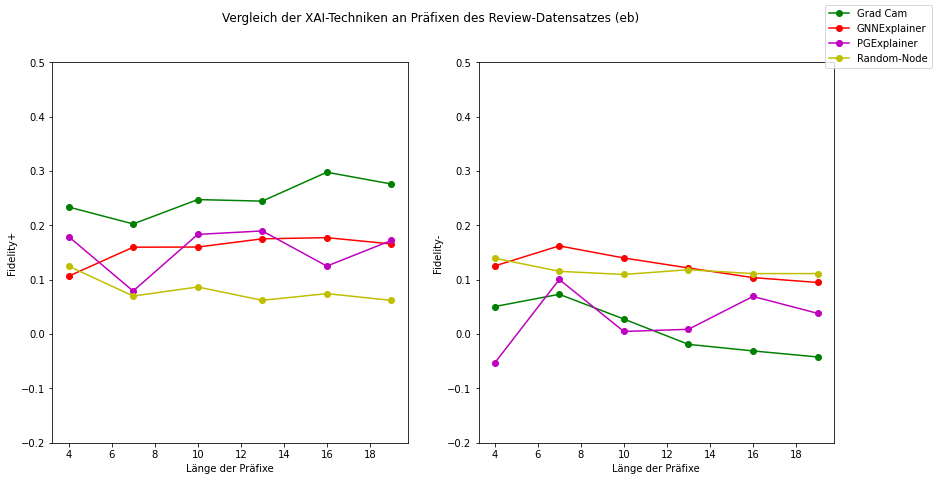

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_results_prefix(dataset_list, "Vergleich der XAI-Techniken an Präfixen des Review-Datensatzes (eb)", path / save_place, sparsity_fidelity_grad_cam, \
             sparsity_fidelity_inv_grad_cam, sparsity_fidelity_gnne, sparsity_fidelity_inv_gnne, sparsity_fidelity_pge, sparsity_fidelity_inv_pge, sparsity_fidelity_random_node, sparsity_fidelity_inv_random_node )